Exercício #1

In [0]:
import urllib.request
import cv2
import imutils
import numpy as np         
import pandas as pd        
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours

In [0]:
def read_image_from_drive(url, type):
  resp = urllib.request.urlopen(url)
  img_byte = np.asarray(bytearray(resp.read()), dtype="uint8")
  if type == 0:
    return cv2.imdecode(img_byte, cv2.IMREAD_GRAYSCALE)
  else:
    img = cv2.imdecode(img_byte, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

In [0]:
def plot_images_inline(imgs):
  fig = plt.figure()
  for n, img in enumerate(imgs):
      fig.add_subplot(1, np.ceil(len(imgs)/float(1)), n + 1)
      plt.imshow(img, cmap='gray')

  fig.set_size_inches(np.array(fig.get_size_inches()) * len(imgs))
  plt.show()

In [0]:
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [0]:
image = read_image_from_drive('https://docs.google.com/uc?export=download&id=1wNp_geQgGndwOKlkK13yrIDd1Xft-OI1', 1)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)
 
edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)
 
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

(cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = None

Nesta etapa estamos iterando os contornos e coletando os pontos que formam a região do objeto, assim como os valores de distância Euclidiana de altura e largura

In [0]:
boxes, dAs, dBs = [], [], []

for c in cnts:
  box = cv2.minAreaRect(c)
  box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
  box = np.array(box, dtype="int")
  box = perspective.order_points(box)

  (tl, tr, br, bl) = box
  boxes.append(box)
  (tltrX, tltrY) = midpoint(tl, tr)
  (blbrX, blbrY) = midpoint(bl, br)
  (tlblX, tlblY) = midpoint(tl, bl)
  (trbrX, trbrY) = midpoint(tr, br)

  dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
  dAs.append(dA)
  dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
  dBs.append(dB)

Nesta etapa, vamos extrair os pixels de cada objeto e calcular a média

[107.08261494252874, 198.74844953315613, 52.52046783625731, 91.50624687656172, 92.015485641478, 58.7927536231884]


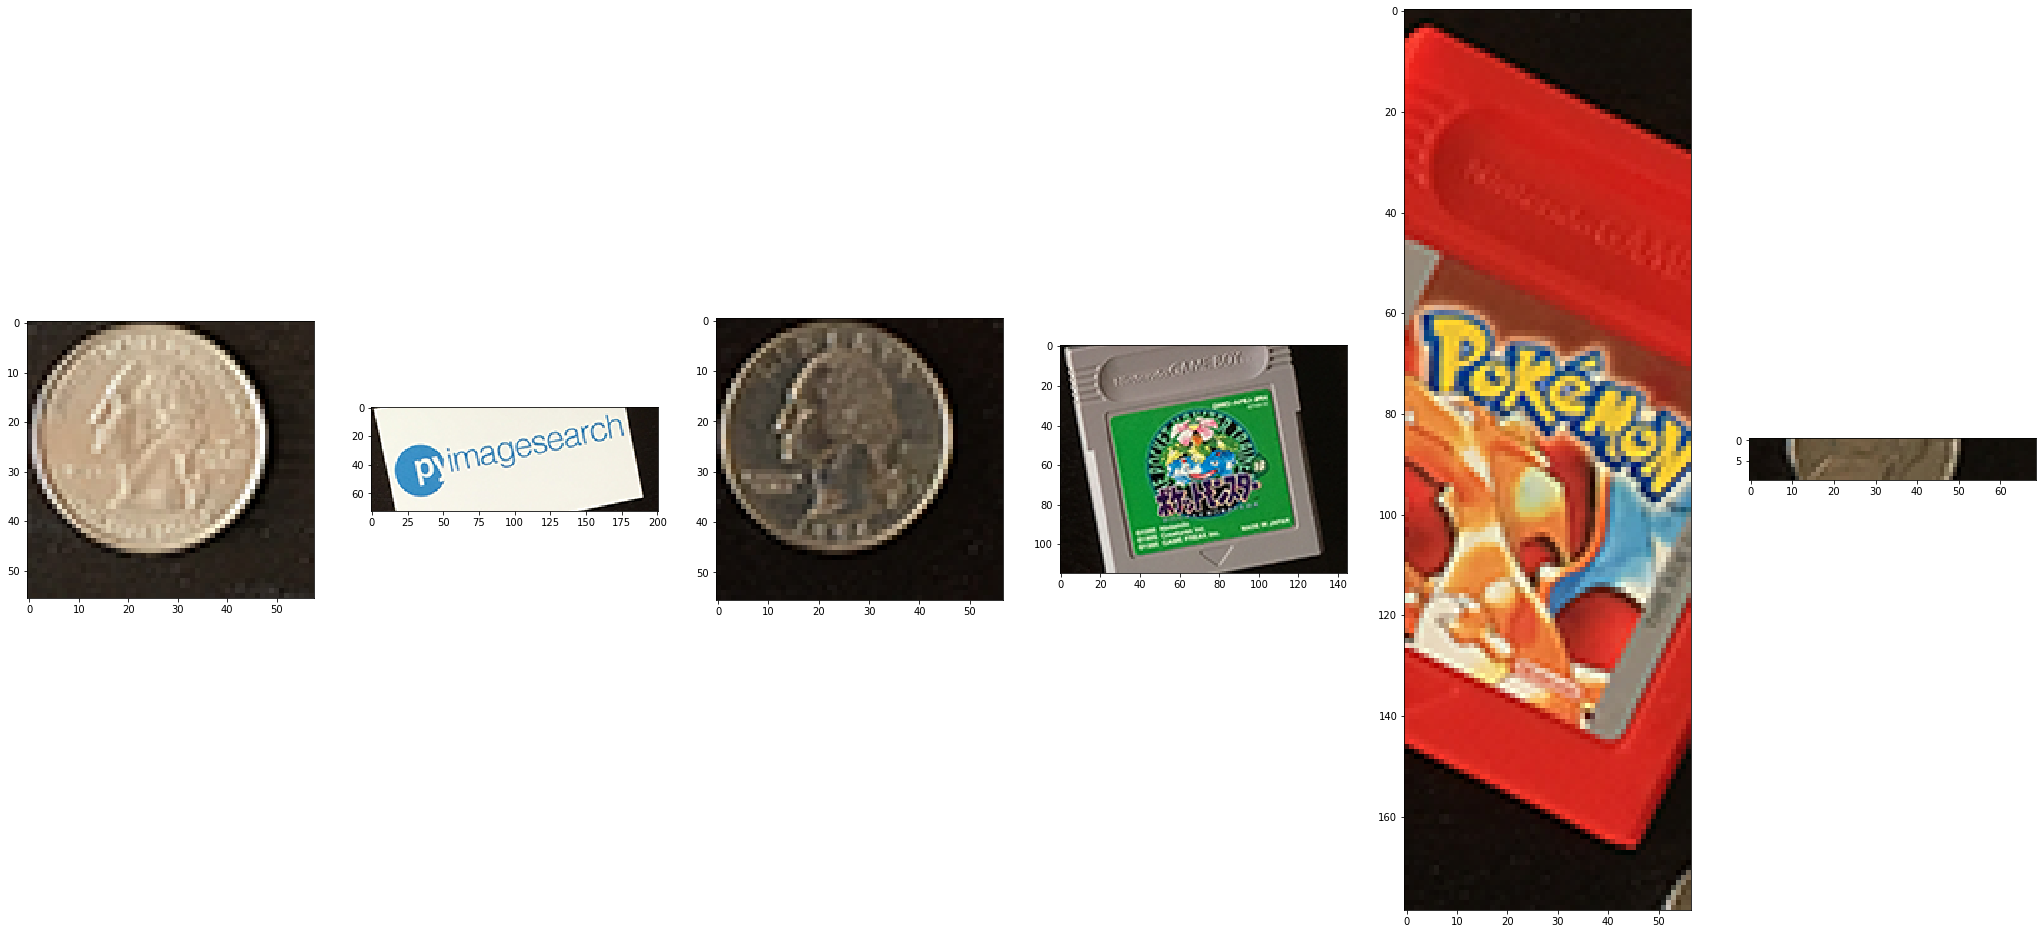

In [0]:
imgs = []
meanValues = []
for box in boxes:
  (tl, tr, br, bl) = box
  crop = image[int(tl[1]):int(br[1])+10, int(tl[0]):int(br[0])+10]
  meanValues.append(crop.flatten().sum() / len(crop.flatten()))
  imgs.append(crop) 

print(meanValues)
plot_images_inline(imgs)

Atráves da média sabemos qual o objeto que contém o maior número de pixels puxando para o valor mais alto, ou seja, mais próximo do valor 255 (branco) 

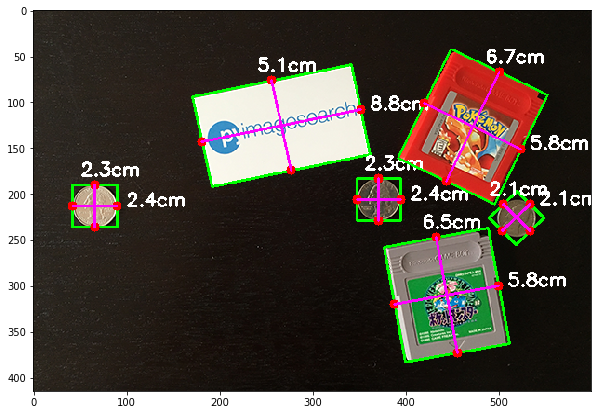

In [0]:
valorRef = 8.8
# sabemos que o indice 1 (segundo elemento) é o objeto mais branco
# se você observer o mesmo indixe 1 dos contornos se referem a este objeto
# tomamos este cuidado ao longo do desenvolvimento
indexRef = 1 

pixelsPerMetric = dBs[1] / valorRef

for i, c in enumerate(cnts):
  cv2.drawContours(image, [boxes[i].astype("int")], -1, (0, 255, 0), 2)

  (tl, tr, br, bl) = boxes[i]
  (tltrX, tltrY) = midpoint(tl, tr)
  (blbrX, blbrY) = midpoint(bl, br)
  (tlblX, tlblY) = midpoint(tl, bl)
  (trbrX, trbrY) = midpoint(tr, br)

  cv2.circle(image, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
  cv2.circle(image, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
  cv2.circle(image, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
  cv2.circle(image, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
 
  cv2.line(image, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
    (255, 0, 255), 2)
  cv2.line(image, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
    (255, 0, 255), 2)
  
  dimA = dAs[i] / pixelsPerMetric
  dimB = dBs[i] / pixelsPerMetric
 
  cv2.putText(image, "{:.1f}cm".format(dimA),
    (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
    0.65, (255, 255, 255), 2)
  cv2.putText(image, "{:.1f}cm".format(dimB),
    (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
    0.65, (255, 255, 255), 2)
 
plt.figure(figsize = (10,7))	
plt.imshow(image, aspect='auto')